<a href="https://colab.research.google.com/github/Yuhala/project-based-learning/blob/master/CUSO_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A gentle introduction to Graph Neural Networks

This session will introduce you to the basic concepts of graph neural networks. We will be using the popular deep learning framework pytorch and the graph specific PyG framework. Let's start with installing all the dependencies that we will need. Throughout this tutorial, we will use [pyG](https://https://pytorch-geometric.readthedocs.io/en/latest/), a graph learning framework built on top of pytorch.

In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

import networkx

import torch
from torch import nn
import random
import numpy as np

from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv import MessagePassing

2.1.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We also provide a function that can be used to visualize graphs later.

In [3]:
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import torch_geometric.utils as utils

# draw a pyG graph
def visualize_datapt(data):
    X = data.x
    Y = data.y
    g = to_networkx(data)
    gl_x = {i:(i) for i,x in enumerate(X)}
    layout = nx.spring_layout(g)
    pY, pX = None, None
    inp = len(X[0])
    if inp == 1:
      pX = [(x.item(),x.item(),1-abs(x.item())) for x in X]
      pY = [(x.item(),1-abs(x.item()),x.item()) for x in Y]
    elif inp == 2:
      pX = [(x[0].item(),x[0].item(),1-abs(x[0].item())) for x in X]
      pY = [(x.item(),1-abs(x.item()),x.item()) for x in Y]
    plt.subplot(121)
    nx.draw(g, pos=layout, with_labels = True, node_color=pX, labels=gl_x)
    plt.subplot(122)
    nx.draw(g, pos=layout, with_labels = True, node_color=pY)
    plt.show()

# Doesn't assume labels
def visualize_graph(data):
    G = utils.to_networkx(data)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

#BLOCK 1: Pytorch Geometric Basics


##Graph Representation in Pytorch

Before we can start training a model, we need to think about how our graphs will be represented. While an adjacency matrix would be a valid option, it grows quadratically in the size of nodes, which consumes more memory than necessary when dealing with sparse graphs. This is why we use a tensor of shape (2, #edges) (A tensor can be understood as a multidimensional array) that contains pairs of node id's that represent (directed) edges (also known as COO format). For undirected edges we can simply add both directed edges.

In [5]:
# The edge_index fully defines the graph topology
edge_index = torch.tensor([[0, 1, 1, 2, 3 , 4, 5, 5],
                           [1, 0, 2, 1, 2, 3, 4, 1]], dtype=torch.long)

When learning with graphs, we typically endow nodes with some information, also referred to as features. This can be done with a tensor of shape (#nodes, #features).

In [9]:
x = torch.tensor([[0.5], [0], [1], [0], [1], [0.1]], dtype=torch.float)

In this notebook, we will deal with one specific instance of Machine Learning: supervised learning. The basic workflow is as follows: We are given a training dataset of graphs and their node features, as well as ground truth labels, for example for nodes. We then use this training dataset to fit a model, teaching it to map graphs to the right predictions. Once we are done with the training, we test the performance of the model on fresh data that it has not seen previously.
To define the ground-truth data, we define a new tensor of size #nodes.

In [7]:
#Here, we have one (binary) class label per node
y = torch.tensor([[0], [1], [1], [0], [1], [1]], dtype=torch.float)

Once we have all the necessary data, we can combine the edge_index, node features and ground-truth labels into one data object

In [10]:
torch_graph = Data(x=x, edge_index=edge_index, y=y)


Let's look at the resulting data point.

Torch graph object:
Data(x=[6, 1], edge_index=[2, 8], y=[6, 1])
Node features
tensor([[0.5000],
        [0.0000],
        [1.0000],
        [0.0000],
        [1.0000],
        [0.1000]])
Edge index
tensor([[0, 1, 1, 2, 3, 4, 5, 5],
        [1, 0, 2, 1, 2, 3, 4, 1]])


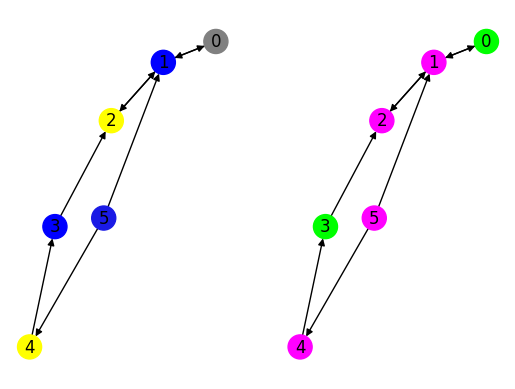

In [18]:
print("Torch graph object:")
print(torch_graph)
print("Node features")
print(torch_graph.x)
print("Edge index")
print(torch_graph.edge_index)

visualize_datapt(torch_graph)

On the left, nodes are colored regarding their features. The right graph shows the ground-truth labels in different colors.

## Graphs from networkx
PyG makes it easy to convert graphs from frameworks such as networkx into its own format. This can simplify the generation of new dataopints significantly.

Data(edge_index=[2, 92], num_nodes=24)


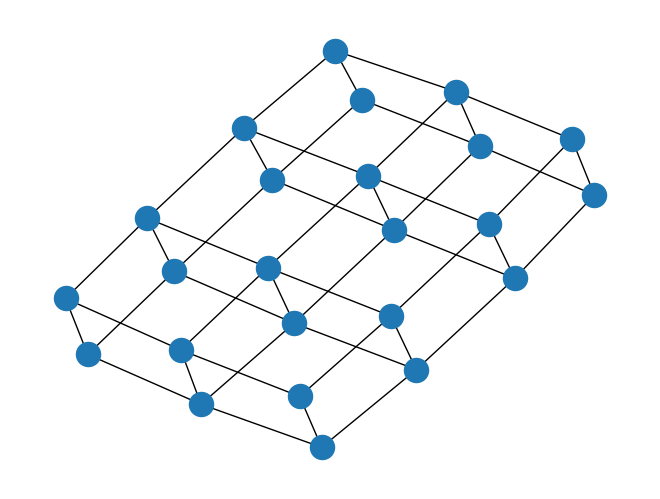

In [19]:
g = nx.grid_graph([2,4,3])
nx.draw(g)

# All we need is one function call
networkx_graph = from_networkx(g)
print(networkx_graph)

We can use our newly acquired knowledge to create complete datasets now. In this first example, we create random trees in networkx and label leafs for the ground-truth. This means that the task we want to solve is identifying whether a given node is a leaf or not. As nodes do not have features in this task, we simply provide all nodes with the same initial feature.

In [20]:
class Trees():
    def __init__(self):
        super().__init__()

    def gen_graph(self, num_nodes, num):
        nx_graph = nx.random_tree(n=num_nodes, seed=num)
        tree = from_networkx(nx_graph)
        leafs = [x for x in nx_graph.nodes() if nx_graph.degree(x)==1]
        tree.x = torch.ones(num_nodes, 1)
        tree.y = torch.zeros(num_nodes)
        for node in leafs:
            tree.y[node] = 1
        return tree

    def makedata(self, num_graphs = 200, num_nodes = 8):
        return [self.gen_graph(num_nodes, i) for i in range(num_graphs)]


data = Trees().makedata(num_graphs = 20, num_nodes = 8)

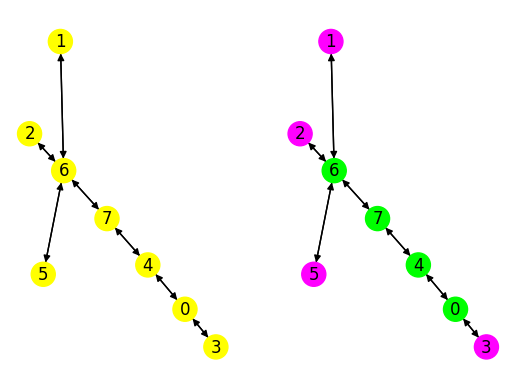

In [21]:
# The dataset is just a list of data objects
visualize_datapt(data[0])

### Batching in pyG
When training a machine-learning model, we usually want to train with multiple datapoints/graphs at the same, also because we can make use of parallel computations on our GPU. pyG has a unique approach to dealing with multiple graphs simultaneously, which we will look at now. Let's generate two simple graphs first.

In [22]:
graph1 = Data(x=torch.tensor([[1.0], [2.0], [3.0]]),
              edge_index=torch.tensor([[0, 1, 1, 2],
                                      [1, 0, 2, 1]]))
graph2 = Data(x=torch.tensor([[10.0], [11.0], [12.0], [13.0]]),
              edge_index=torch.tensor([[0, 1, 1, 2, 2, 3, 3, 0],
                                      [1, 0, 2, 1, 3, 2, 0, 3]]))

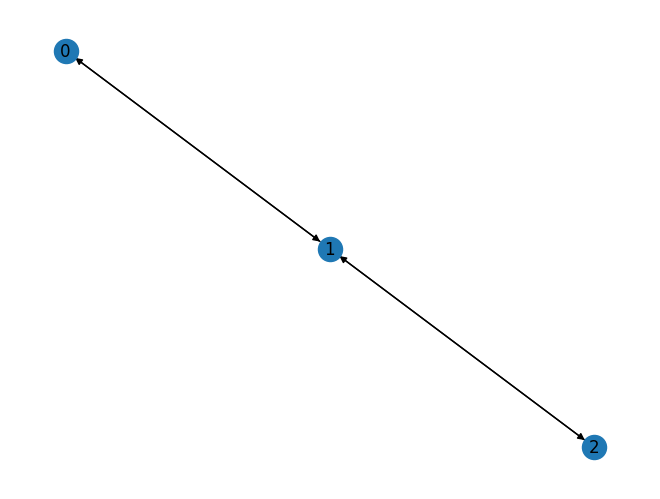

In [23]:
visualize_graph(graph1)

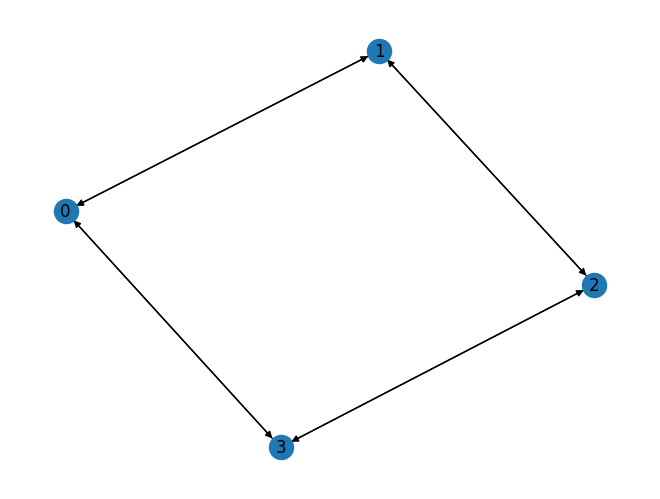

In [24]:
visualize_graph(graph2)

What we actually want to do when batching graphs is to concatenate all tensors (like `x` for labels, the `edge_index` and possibly also predictions `y`) such that the resulting object looks like a normal data object, but actually contains multiple disconnected components that represent our graphs. pyG offers a simple interface for this:

In [26]:
from torch_geometric.data import Batch
batch = Batch.from_data_list([graph1, graph2])

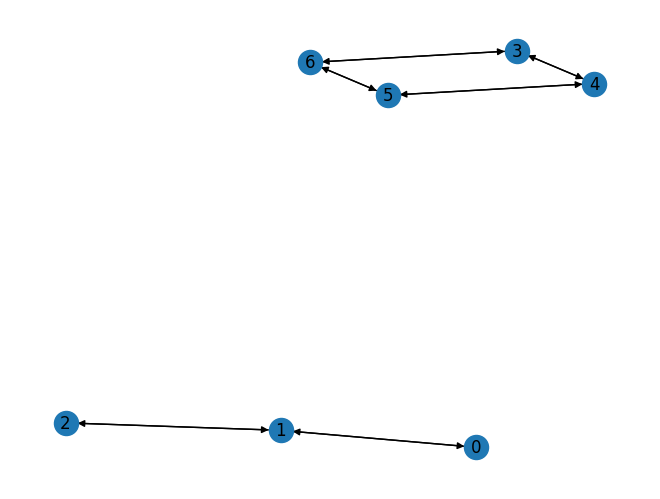

In [27]:
visualize_graph(batch)

Let's look at how the batch was created more closely.

In [29]:
print(batch)
print(batch.x)
print(batch.edge_index)

DataBatch(x=[7, 1], edge_index=[2, 12], batch=[7], ptr=[3])
tensor([[ 1.],
        [ 2.],
        [ 3.],
        [10.],
        [11.],
        [12.],
        [13.]])
tensor([[0, 1, 1, 2, 3, 4, 4, 5, 5, 6, 6, 3],
        [1, 0, 2, 1, 4, 3, 5, 4, 6, 5, 3, 6]])


The labels `x` were simply concatenated, while the `edge_index` requires special attention. To keep the nodes of the two graphs in separate components, the id's of nodes in the second graph are shifted by the number of nodes in the first graph.
In addition to `x` and `edge_index`, the data object now also contains two new attributes, `batch` and `ptr`. While `ptr` doesn't have to concern us too much for now, `batch` is important, as it allows us to do the inverse mapping from a batch to its individual graphs ("debatching").

In [30]:
batch.batch

tensor([0, 0, 0, 1, 1, 1, 1])

To facilitate this, the tensor keeps track of the indices of the graph that every node belongs to. In this case, they are `0` and `1`. This information is important when we want to apply some operations seperately on every graph in a batch, like global pooling (more on that later).

##First GNN
Let's implement our first Graph Neural Network using a graph convolution called GIN ([paper](https://arxiv.org/pdf/1810.00826.pdf)). The update rule for GIN is defined as:

$\displaystyle x_v^{(t+1)} = \Theta((1+\epsilon)\cdot x_v^{(t)} + \sum_{u \in N(v)} x_u^{(t)})$

where $x_v^{(t)}$ is the embedding of node $v$ at iteration $t$. In every iteration we execute the convolution synchronously for all nodes. For every node $v$, it aggreagates all neighboring states by summing them up and combining them with the old state of $v$ (using some learnable parameter $\epsilon$). The result is then passed through the MLP $\Theta$.
Let's see how to use this convolutional layer.

In [31]:
import torch
import torch.nn.functional as F
# The GIN convolution itself is already implemented and ready to use
from torch_geometric.nn import GINConv

# A GNN looks very similar to any other neural network that we implement in pytorch
class GIN(torch.nn.Module):
    # The constructor creates all neural networks that we need to run the model, but doesn't run them yet.
    def __init__(self):
        super().__init__()
        # In this example, we want to run two separate GIN convolutions with different parameters
        # We first create the MLPs \Theta for the two convolutions
        # The first convolution takes the one-dimensional input labels and maps them to 4-dimensional embeddings
        self.network1 = torch.nn.Sequential(torch.nn.Linear(1, 4), torch.nn.ReLU())
        # These 4-dimensional embeddings are used as input for the second convoluion, which maps them to outputs for the two classes we want to predict
        self.network2 = torch.nn.Sequential(torch.nn.Linear(4, 2), torch.nn.ReLU())

        # Finally, we can use the networks to construct the two convolutions
        self.conv1 = GINConv(nn = self.network1)
        self.conv2 = GINConv(nn = self.network2)

    # The forward pass uses the networks that were defined in the constructor and evaluates them on given data
    def forward(self, data):
        # From the data, we get the node features x and the edge index
        x, edge_index = data.x, data.edge_index

        # We pass x and edge_index to the convolutions
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)

        # Here we apply a log_softmax to get class probablities for the two outputs
        return F.log_softmax(x, dim=1)

Now that we have our first GNN, let's use it on a dataset! The Tree dataset contains trees with leaf nodes marked as 1 and non-leaf nodes as 0 in the ground-truth. But first, we need some boilerplate code for our training loop. There is nothing unexpected here, we just run 20 epochs of training.

In [32]:
import torch.optim as optim

def train_model(model, dataset):
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  val_split = 0.8

  np.random.shuffle(dataset)
  train_size = int(val_split*len(dataset))
  train_loader = DataLoader(dataset[:train_size], batch_size=1, shuffle=True)
  model.train()
  device = torch.device('cpu')
  for epoch in range(20):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          optimizer.zero_grad()
          data = data.to(device)
          pred = model(data)

          loss = criterion(pred, data.y.to(torch.long))
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader.dataset):.5f}')
      running_loss = 0.0

In [33]:
# Fix seeds for good measure
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Use the tree dataset
dataset = Trees().makedata(num_graphs = 200, num_nodes = 8)

model = GIN()
# Let's go!
train_model(model, dataset)

Epoch: 1 loss: 0.49278
Epoch: 2 loss: 0.37133
Epoch: 3 loss: 0.29888
Epoch: 4 loss: 0.25045
Epoch: 5 loss: 0.21871
Epoch: 6 loss: 0.19129
Epoch: 7 loss: 0.17390
Epoch: 8 loss: 0.14338
Epoch: 9 loss: 0.11353
Epoch: 10 loss: 0.08962
Epoch: 11 loss: 0.07297
Epoch: 12 loss: 0.06345
Epoch: 13 loss: 0.05541
Epoch: 14 loss: 0.04942
Epoch: 15 loss: 0.04330
Epoch: 16 loss: 0.03888
Epoch: 17 loss: 0.03494
Epoch: 18 loss: 0.03098
Epoch: 19 loss: 0.02774
Epoch: 20 loss: 0.02537


Until now we used the GIN convolution that is already provided by pytorch geometric. A nice comprehensive overview of all provided convolutions can be found here: [link](https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html). Now what if we want to get more advanced and use our own convolution? In the following code snippet a new convolutional layer is defined.

In [35]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import MessagePassing

# The secret is to use the MessagePassing class
class CustomMP(MessagePassing):
    def __init__(self, edge_nn, nn):
        super(CustomMP, self).__init__(aggr='add')
        self.edge_nn = edge_nn
        self.nn = nn

    def forward(self, x, edge_index):
        return self.nn(x + self.propagate(edge_index, x=x))

    # access receiver x_i and sender x_j
    def message(self, x_j, x_i):
      # more elaborate example to look at both endpoints of an edge
      concatted = torch.cat((x_j, x_i), dim=1)
      return self.edge_nn(concatted)

# This is a GNN as before that uses the new convolutional layer
class AdvancedGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(torch.nn.Linear(8, 2), torch.nn.ReLU())
        self.edge_network = torch.nn.Sequential(torch.nn.Linear(2, 8), torch.nn.ReLU())
        self.conv3 = CustomMP(edge_nn = self.edge_network, nn = self.network)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)

You should now understand the basics of GNNs and are finally ready for your first real challenge using GNNs. For the next task you will only need one more small thing: What if we want to do a prediction for the whole graph and not on a per-node level? In this case we have to do what GNN people call pooling to combine the embeddings of all nodes into one final output. This is usually done by applying a permutation invariant aggregation (sum, mean, max, min, ...) and optionally using a MLP on the aggregate. You will get more information on this in the skeleton of the next task.

##Chess Prediction Task

We are given social networks of novice chess players. The edges consist of a single real $e_{ij} \in [0,1]$ indicating the playing frequency between player $i$ and player $j$.

It has been observed that after some time either the players in the network stop playing chess or the network as a whole matures into a chess community.
We know a few factors that are essential to a network to mature into a chess community:
- In a chess community there are players considered to be _chess masters_.
- _chess master_ players have several friends that are considered _frequent players_.

We don't know exactly how many chess masters there are in a chess community nor how to exactly define a frequent player. However we know that it somehow depends on the frequency and the play with other friends (as indicated by the edges in the graph).

Given a dataset of such novice chess social networks determine if a network matures into a chess communmity.

In [37]:
%%capture
! wget -O chess_graphs.pt https://polybox.ethz.ch/index.php/s/R1OJDjSaY5pYXYF/download

In [44]:
chess_graphs = torch.load('chess_graphs.pt')


Some helper functions to evaluate perfomance

In [43]:
! lsb_release -a



No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [45]:
def eval_model_comp(model, dataset):
  model.eval()
  acc = 0
  device = torch.device('cpu')
  tot_nodes = 0
  perf = 0
  gpred = []
  gsol = []
  for step, batch in enumerate(dataset):
      tot_nodes += 1
      with torch.no_grad():
        batch = batch.to(device)
        pred = model(batch)

      y_pred = torch.argmax(pred,dim=1)
      graph_acc = torch.sum(y_pred == batch.y).item()
      acc += graph_acc

  acc = acc
  return acc/tot_nodes


The starting skeleton for the chess gnn

In [49]:
from torch_geometric.nn import global_add_pool,global_mean_pool,global_max_pool

class Conv1(MessagePassing):
  def __init__(self):
    # possible aggregations are 'mean', 'max', 'min' or 'add'
    # hint: might consider to add an mlp after the propagation
    super(Conv1, self).__init__(aggr='mean')

  def forward(self, edge_index, edge_attr):
    return self.propagate(edge_index, edge_attr=edge_attr)

  def message(self, edge_attr):
    return edge_attr

class Conv2(MessagePassing):
  def __init__(self):
    super(Conv2, self).__init__(aggr='mean')
    # hint: might consider to add an mlp after the propagation

  def forward(self, x, edge_index):
    return self.propagate(edge_index, x=x)


class ChessGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sample_nn = torch.nn.Sequential(torch.nn.Linear(1, 2), torch.nn.ReLU(), torch.nn.Linear(2, 2), torch.nn.ReLU())
        self.conv1 = Conv1()
        self.conv2 = Conv2()

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch


        # specify the graph convolutions
        x = self.conv1(edge_index, edge_attr) # first convolution should consider the edge feature
        x = self.conv2(x, edge_index)

        # prediction class is to classify graphs -> need to pool the node information
        # possible pooling layers are global_add_pool, global_mean_pool, global_max_pool
        # The pooling operation works on a batch of graphs and thus outputs as many elements in the tensor as there are graphs
        x = global_add_pool(x, batch)

        # x should be logits for 2 classes
        return F.log_softmax(x, dim=1)

Training loop for the chess gnn

In [50]:
import torch.optim as optim

def train_model(model, dataset):
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  val_split = 0.8
  np.random.shuffle(dataset)
  train_size = int(val_split*len(dataset))
  train_loader = DataLoader(dataset[:train_size], batch_size=8 , shuffle=True)
  val_loader = DataLoader(dataset[train_size:], batch_size=1 , shuffle=True)


  model.train()
  device = torch.device('cpu')
  for epoch in range(100):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          optimizer.zero_grad()
          data = data.to(device)

          pred = model(data)
          loss = criterion(pred, data.y.to(torch.long)) #TODO: this does not work... "IndexError: Target 1 is out of bounds."

          loss.backward()
          optimizer.step()

          running_loss += loss.item()*data.num_graphs

      print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader.dataset):.5f} validation set accuracy: {eval_model_comp(model, val_loader)}')
      running_loss = 0.0

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model = ChessGNN()
train_model(model, chess_graphs)

# with the right architecture you should be able to solve the task in about 50 epochs

IndexError: Target 1 is out of bounds.

# BLOCK 2: ESCAPE THE MAZE


In this block you will solve a very practical task, how to find your way in a maze! First, let's look at the concrete task.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def create_dataset(size, num_mazes):
  images = []
  graphs = []
  x = []
  y = []
  for _ in range(num_mazes):
    G = nx.grid_2d_graph(size[0], size[1])
    for e in G.edges():
      G[e[0]][e[1]]['weight'] = random.uniform(0, 1)
    T = nx.minimum_spanning_tree(G)
    start, end = random.sample(list(T.nodes), k=2)
    path = nx.shortest_path(T, source=start, target=end)

    # Add graph
    T.colors = ['blue' if n in [start, end] else 'green' for n in T.nodes]
    graphs.append(T)

    # Create images
    image = np.zeros((size[0]*2+1,size[1]*2+1))
    image_solution = np.zeros((size[0]*2+1,size[1]*2+1))
    for e in T.edges():
      image[e[0][0] + e[1][0] + 1][e[0][1] + e[1][1] + 1] = 1
      image_solution[e[0][0] + e[1][0] + 1][e[0][1] + e[1][1] + 1] = 1 if not (e[0] in path and e[1] in path) else 2
    for n in T.nodes():
      image[n[0]*2+1][n[1]*2+1] = 2 if n in [start, end] else 1
      image_solution[n[0]*2+1][n[1]*2+1] = 2 if n in [start, end] else (1 if not n in path else 2)
    images.append((F.one_hot(torch.tensor(image, dtype=torch.int64)), F.one_hot(torch.tensor(image_solution, dtype=torch.int64))))
  return images, graphs

import torchvision

def show_graph_and_images(graph, images):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
  nx.draw(graphs[0], pos={node: (node[1], 4-node[0]) for node in graph.nodes}, node_color = graph.colors, ax=ax1)
  ax2.imshow(torchvision.transforms.ToPILImage()(images[0].permute(2, 0, 1).float()), interpolation="none")
  ax3.imshow(torchvision.transforms.ToPILImage()(images[1].permute(2, 0, 1).float()), interpolation="none")

We generate mazes on a grid of a fixed size and create two different versions of the same dataset. First, we can represent mazes as images. The input for the task are two points (pixels) in the maze that are marked with the same color. We have to find the (unique) path between these two points and mark them in the output. Instead of representing a maze as an image, we can also use graphs for this task. The next cell shows the graph representation of a maze, the according image to the right of it and the ground truth for the image.

In [ ]:
images, graphs = create_dataset((4, 4), 10)
show_graph_and_images(graphs[0], images[0])

The advantage of using GNNs for this task is that we can apply the same network to graphs of arbitrary sizes. This makes it possible to train on relatively small example graphs and hopefully generalize to much bigger instances. The dataset generation function allows us to generate larger instances too so we can test for that:

In [ ]:
images, graphs = create_dataset((8, 8), 10)
show_graph_and_images(graphs[0], images[0])

## Train your own GNN

Now it's your turn, train a graph neural network to escape the maze! The following function creates the dataset containing pyG graphs for you (the previous version only created networkx graphs and images):

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def create_dataset_graph(sizes = []):
  graphs = []
  counternodes = 0
  graphIDcounter = 0
  for num_mazes, size in sizes:
    def h(x):
      return x[1]+size[1]*x[0]
    for graphID in range(num_mazes):
      num_nodes = size[0]*size[1]
      G = nx.grid_2d_graph(size[0], size[1])
      for e in G.edges():
        G[e[0]][e[1]]['weight'] = random.uniform(0, 1)
      T = nx.minimum_spanning_tree(G)
      start, end = random.sample(list(T.nodes), k=2)
      path = nx.shortest_path(T, source=start, target=end)

      graph = from_networkx(T)
      graph.x = torch.zeros(num_nodes, 2)
      graph.x[:,1] = 1
      start = h(start)
      end = h(end)
      graph.x[start] = 1
      graph.x[start][1] = 0
      graph.x[end][0] = 1
      graph.x[end][1] = 0
      graph.y = torch.zeros(num_nodes)
      graph.ids = torch.zeros(num_nodes)
      graph.graphID = graphIDcounter
      for node in T.nodes:
        graph.ids[h(node)] = counternodes + h(node)
      for node in path:
        graph.y[h(node)] = 1
      graphs.append(graph)
      counternodes += num_nodes
      graphIDcounter += 1
  return graphs

In [ ]:
training_graphs = create_dataset_graph(sizes = [(200,(4,4))])

We provide a function to evaluate the performance of the model. As the distribution of ground truth values tends to be unbalanced (especially for larger graphs), we use the F1 score. Our model will apply the same update rule recurrently. Of course, the number of iterations (and thus node updates) that we need to solve the maze depends on specific instance and size of the graph. To keep things simple, we define a ratio and let the GNN update for `RATIO*n` steps. Feel free to change the ratio if you like to.

In [ ]:
RATIO = 1

In [ ]:
from torchmetrics import F1Score

def eval_model_comp(model, dataset, mode = None):
  model.eval()
  acc = 0
  device = torch.device('cpu')
  tot_nodes = 0
  tot_graphs = 0
  perf = 0
  gpred = []
  gsol = []
  for step, batch in enumerate(dataset):
      n = len(batch.x)/batch.num_graphs
      with torch.no_grad():
        batch = batch.to(device)
        pred = model(batch, int(RATIO*n))

      if mode == "small":
        if n > 4*4:
          break
      elif mode == "medium":
        if n > 8*8:
          break
      elif mode == "large":
        if n > 16*16:
          break
      y_pred = torch.argmax(pred,dim=1)
      graph_acc = torch.sum(y_pred == batch.y).item()
      tot_nodes += len(batch.x)
      tot_graphs += batch.num_graphs
      acc += graph_acc
      for p in y_pred:
        gpred.append(int(p.item()))
      for p in batch.y:
        gsol.append(int(p.item()))
      if graph_acc == n:
        perf += 1
  from sklearn.metrics import f1_score
  gpred = torch.tensor(gpred)
  gsol = torch.tensor(gsol)
  f1score = f1_score(gpred, gsol)
  acc = acc
  return (perf/tot_graphs, acc/tot_nodes, f1score)

def eval_model(model, dataset, mode = None):
  d = DataLoader(dataset, batch_size=1)
  a,b,c = eval_model_comp(model, d, mode = mode)
  print(f"node accuracy: {b:.3f} | node f1 score: {c:.3f} | graph accuracy: {a:.3}")

### Maze GNN
To make it easier to start, we provide a skeleton for the GNN that you can complete.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import MessagePassing

class MazeConv(MessagePassing):
    def __init__(self):
      super(MazeConv, self).__init__(aggr='add')
      #TODO
      #initialize custom message passing


    def forward(self, x, edge_index):
      #TODO
      #define own computation, call the round with
      #self.propagate(edge_index, x=x)
      return x

    def message(self, x_j, x_i):
      #TODO
      #define the custom message that gnns exchange
      return x_j


class MazeGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = 0.2

        hidden_dim = 8

        # we recommend using a larger dimension during the graph computation
        # therefore the encoder and decoder map in-/output to the used dimension
        self.encoder = self.get_mlp(2,8,hidden_dim)
        self.decoder = self.get_mlp(hidden_dim,32,2)

        self.conv = MazeConv()

    # get the graph and number of nodes in the graph
    def forward(self, data, num_nodes):
      #things to consider:
      # how many convolutions do we need to execute?
      # what kind of custom convolution could help
      # do we want a skip connection between layers?

      x, edge_index = data.x, data.edge_index
      input = x

      x = self.encoder(x)

      #------------------------
      # Here you should specify the graph computations

      x = self.conv(x, edge_index)

      #------------------------

      x = self.decoder(x)

      #output is logits of belonging to two classes
      return F.log_softmax(x, dim=1)


    # helper function - generates an MLP w. relu activation with 3 layers
    def get_mlp(self, input_dim, hidden_dim, output_dim, last_relu = True):
        modules = [torch.nn.Linear(input_dim, int(hidden_dim)), torch.nn.ReLU(), torch.nn.Dropout(self.dropout), torch.nn.Linear(int(hidden_dim), output_dim)]
        if last_relu:
            modules.append(torch.nn.ReLU())
        return torch.nn.Sequential(*modules)


And we provide boilerplate training code as well, feel free to adapt it!

In [ ]:
import torch.optim as optim

def train_maze_model(model):
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  dataset = training_graphs
  val_split = 0.8

  np.random.shuffle(dataset)
  train_size = int(val_split*len(dataset))
  train_loader = DataLoader(dataset[:train_size], batch_size=1, shuffle=True)
  val_set = dataset[train_size:]

  model.train()
  device = torch.device('cpu')


  for epoch in range(20):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          optimizer.zero_grad()
          data = data.to(device)


          # you can change additional parameters here
          pred = model(data, data.num_nodes)

          loss = criterion(pred, data.y.to(torch.long))



          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()

          running_loss += loss.item()
      print(f'Epoch: {epoch + 1} loss: {running_loss / len(train_loader.dataset):.5f}')
      print("performance on validation set")
      eval_model(model, val_set)
      running_loss = 0.0

In [ ]:
#set seeds for reproducability
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

maze_model = MazeGNN()
train_maze_model(maze_model)

Our aim is to train a model that works well with different graph sizes, we generate our evaluation data as follows:

In [ ]:
eval_dataset = create_dataset_graph(sizes = [(200,(4,4)), (200,(8,8)), (200,(12,12))])

Finally, we can test our model. How good can you get?

In [ ]:
eval_model(maze_model, eval_dataset)